# Laboratory Exercises: Interpolation and Approximation
### Taylor series, Newton interpolation, Lagrange polynomials, and cubic splines

**Reference:** Chapra & Canale (Taylor series: Ch. 4; Interpolation: Ch. 18)
**Reference:** Chapra & Clough (Taylor series: Ch. 4; Interpolation: Ch. 17)
In this laboratory you will implement and compare several approximation and interpolation techniques:

- Taylor series approximation  
- Lagrange polynomial interpolation  
- Newton polynomial interpolation (divided differences)  
- Cubic spline interpolation  

You will analyze accuracy, stability, and practical performance using numerical experiments in Python.

---
## Learning objectives
By the end of this lab you should be able to:
- Approximate a function locally using a **Taylor series** and analyze truncation error.
- Build a **global polynomial interpolant** using **Lagrange** form.
- Build the same interpolant using **Newton (divided differences)** form and explain its computational advantages.
- Use **cubic splines** as a stable, smooth alternative to high-degree polynomials.
- Compare methods using error metrics and plots (including Runge’s phenomenon).



## General Deliverables
1. Completed Python code (in this notebook, small parts of code are missing (search for TODO)).
2. All requested figures with proper labels and legends (mostly done automatically when you complete the code).
3. Short written answers to the questions in each exercise (you can write them in markdown cells or separate pdf).

## Error Metrics
For a set of evaluation points {x_k}:

- **Maximum absolute error**
  
  $$
  E_\infty = \max_k |f(x_k) - \tilde f(x_k)|
  $$

- **Root-mean-square error**
  
  $$ 
  E_{\text{RMS}} =
  \sqrt{\frac{1}{m}\sum_{k=1}^{m}(f(x_k)-\tilde f(x_k))^2}
  $$



---



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Optional (used in spline section)
try:
    from scipy.interpolate import CubicSpline
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

def max_abs_error(y_true, y_approx):
    return np.max(np.abs(y_true - y_approx))

def rmse(y_true, y_approx):
    return np.sqrt(np.mean((y_true - y_approx)**2))



ModuleNotFoundError: No module named 'numpy'

---

## Exercise 1: Taylor Series Approximation (4 points)

### Objective
Use Taylor series to approximate a smooth function and study truncation error.

### Background
The Taylor series expansion of a function f(x) about a point a is:

$$  
f(x) = f(a) + f'(a)(x-a) + \frac{f''(a)}{2!}(x-a)^2 + \cdots
$$  

For sin(x) expanded about x = 0:

$$
\sin(x) = \sum_{k=0}^{\infty} (-1)^k \frac{x^{2k+1}}{(2k+1)!}
$$

### Tasks
1. Implement a Taylor approximation of sin(x) about x = 0.
2. Evaluate the approximation on:
   $$
   x \in [0,1] \quad \text{and} \quad x \in [0,2\pi].
   $$
3. Plot the absolute error for several truncation orders.
4. Use a logarithmic scale to visualize convergence.

### Questions
1. Why does the approximation degrade away from the expansion point?
2. Where is the approximation most accurate?
3. How many terms are needed for near machine precision on [0,1]?

## Answers 
Q1: 
    The aproximation degrades away from the expansion point because we are using the expansion point as an initial estimation of the function.  

Q2: The aproximation is most accurate when the x value is close to 0

Q3: 10 terms gives a result that appears to be at machine epsilon for the entire interval of [0,1]. But 8 terms is at machine epsilon for most of the interval except for ~[0.82,1]. I would say that 8 terms is "near" machine precision, while 10 terms is at or near machine precision.  


In [ ]:

# ============================================================
# Exercise 1 — Taylor series (sin)
# ============================================================

def taylor_sin(x, n_terms):
    """
    Approximate sin(x) using n_terms of the Taylor series about a=0:
      sin(x) = sum_{k=0..∞} (-1)^k x^(2k+1)/(2k+1)!
    """
     # TODO: implement the series sum
    s=0
    for k in range(n_terms):
        term = ((-1)**k) * x**(2*k+1) / math.factorial(2*k +1)
        s += term
        pass

    return s



In [ ]:
# Quick test (should be close for small x once implemented)
xs = np.array([0.0, 0.2, 1.0])
for x in xs:
    approx = taylor_sin(float(x), n_terms=4)
    print(f"x={x:4.2f}  taylor={approx: .8f}  numpy={np.sin(x): .8f}")

x=0.00  taylor= 0.00000000  numpy= 0.00000000
x=0.20  taylor= 0.19866933  numpy= 0.19866933
x=1.00  taylor= 0.84146825  numpy= 0.84147098


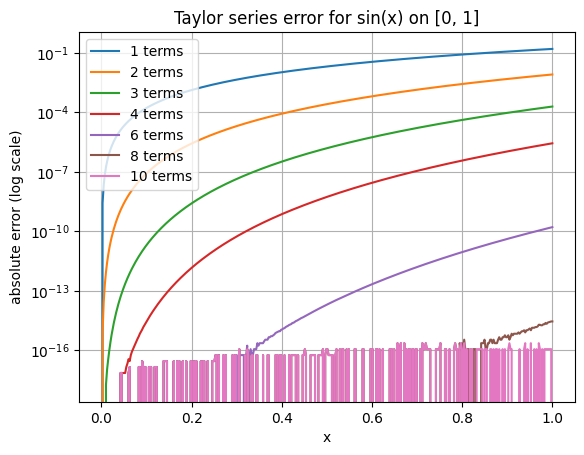

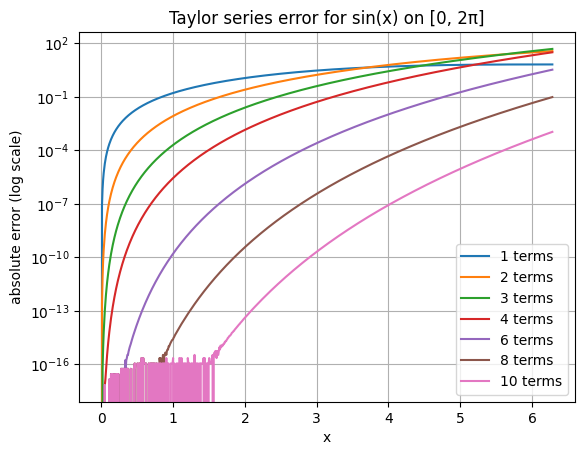

In [ ]:
def run_taylor_error_study():
    x1 = np.linspace(0, 1.0, 400)
    x2 = np.linspace(0, 2*np.pi, 800)

    orders = [1, 2, 3, 4, 6, 8, 10]

    plt.figure()
    for n in orders:
        y_approx = np.array([taylor_sin(xx, n) for xx in x1])
        err = np.abs(np.sin(x1) - y_approx)
        plt.semilogy(x1, err, label=f"{n} terms")
    plt.title("Taylor series error for sin(x) on [0, 1]")
    plt.xlabel("x")
    plt.ylabel("absolute error (log scale)")
    plt.legend()
    plt.grid(True)

    plt.figure()
    for n in orders:
        y_approx = np.array([taylor_sin(xx, n) for xx in x2])
        err = np.abs(np.sin(x2) - y_approx)
        plt.semilogy(x2, err, label=f"{n} terms")
    plt.title("Taylor series error for sin(x) on [0, 2π]")
    plt.xlabel("x")
    plt.ylabel("absolute error (log scale)")
    plt.legend()
    plt.grid(True)

run_taylor_error_study()
plt.show()


## Exercise 2: Lagrange Polynomial Interpolation (4 points)

### Objective
Construct a global polynomial interpolant and observe Runge’s phenomenon.

### Test Function
$$
f(x) = \frac{1}{1 + 25x^2}, \quad x \in [-1,1]
$$

### Background
The Lagrange interpolating polynomial is:

$$
P_n(x) = \sum_{i=0}^{n} y_i L_i(x),
\quad
L_i(x) = \prod_{j\neq i}\frac{x-x_j}{x_i-x_j}
$$

### Tasks
1. Construct the Lagrange interpolating polynomial using equally spaced nodes.
2. Increase the number of nodes and repeat the interpolation.
3. Plot the interpolant, the true function, and the nodes.
4. Compute interpolation errors.

### Questions
1. What happens near the interval boundaries as n increases?
2. Does increasing polynomial degree always improve accuracy?

---



## Answers

Q1: 
    As n increases the lagrange interpolation provides values that are increasingly negative in the subinterval at the boundries of the interval. 
    At the sub interal before the boundry of the interval the lagrange interpolation provides values that are increasingly positive, but are lower in magnitude than those at the edge of the interval. 

Q2: 
    Increasing the polynomial degree does not always improve the accuracy. Based on the graphs below we can see that an increased polynomial degree leads to improved accuracy near the center of the interval, but decreased accuracy near the boundries of the interval.

In [ ]:
def f_runge(x):
    return 1/(1 + 25*x**2)


In [ ]:
# ============================================================
# Exercise 2 — Lagrange interpolation
# ============================================================

def lagrange_interpolate(x_nodes, y_nodes, x_eval):
    """
    Evaluate the Lagrange interpolating polynomial at x_eval.
    x_eval can be a scalar or numpy array.
    """
    x_nodes = np.asarray(x_nodes, dtype=float)
    y_nodes = np.asarray(y_nodes, dtype=float)
    x_eval = np.asarray(x_eval, dtype=float)

    P = np.zeros_like(x_eval, dtype=float)
    n = len(x_nodes)

    # TODO: implement Lagrange basis polynomials
    for i in range(n):
        Li = np.ones_like(x_eval, dtype=float)
        for j in range(n):
            if j != i:
                Li *= (x_eval - x_nodes[j]) / (x_nodes[i] - x_nodes[j])
                pass
        P += y_nodes[i] * Li
        pass
    return P




n= 5  E_inf=4.383e-01  RMSE=2.790e-01
n= 9  E_inf=1.045e+00  RMSE=3.683e-01
n=13  E_inf=3.663e+00  RMSE=9.897e-01
n=17  E_inf=1.439e+01  RMSE=3.271e+00


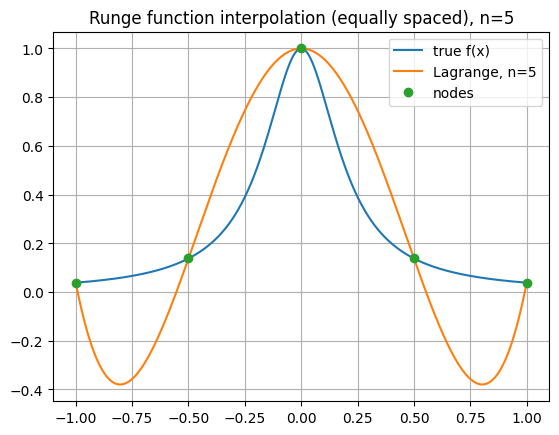

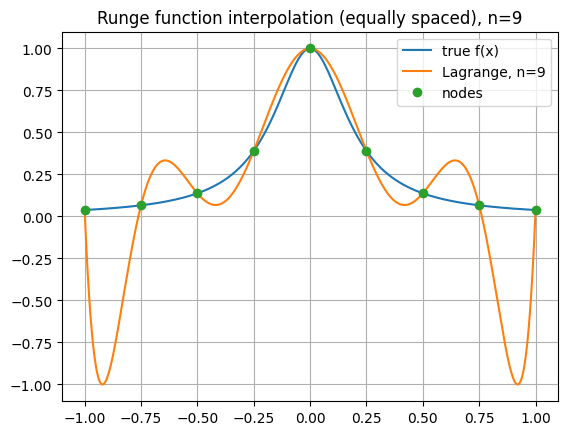

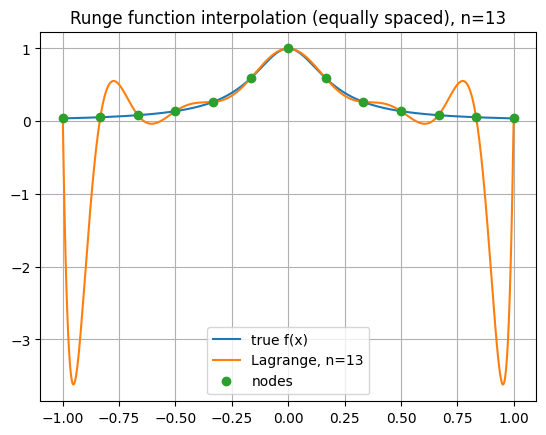

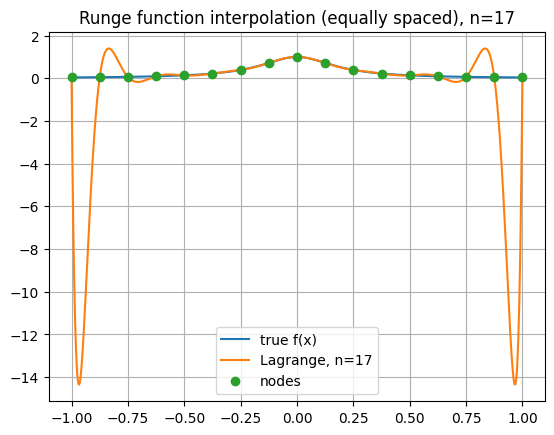

In [ ]:
x_eval = np.linspace(-1, 1, 1000)
y_true = f_runge(x_eval)

for n in [5, 9, 13, 17]:
    x_nodes = np.linspace(-1, 1, n)
    y_nodes = f_runge(x_nodes)
    yL = lagrange_interpolate(x_nodes, y_nodes, x_eval)

    plt.figure()
    plt.plot(x_eval, y_true, label="true f(x)")
    plt.plot(x_eval, yL, label=f"Lagrange, n={n}")
    plt.plot(x_nodes, y_nodes, 'o', label="nodes")
    plt.title(f"Runge function interpolation (equally spaced), n={n}")
    plt.legend()
    plt.grid(True)

    print(f"n={n:2d}  E_inf={max_abs_error(y_true, yL):.3e}  RMSE={rmse(y_true, yL):.3e}")

plt.show()


## Exercise 3: Newton Interpolation (Divided Differences) (4 points)

### Objective
Implement Newton interpolation and compare it with Lagrange interpolation.

### Background
The Newton interpolating polynomial is:

$$
P_n(x) = a_0 + a_1(x-x_0) + a_2(x-x_0)(x-x_1) + \cdots
$$

The coefficients $a_i$ are computed using **divided differences**.
Evaluation is efficiently done with nested multiplication (Horner-like).

## Tasks
1. Implement `divided_differences(x_nodes, y_nodes)` to compute Newton coefficients.
2. Implement `newton_evaluate(x_nodes, coef, x_eval)` to evaluate the Newton polynomial.
3. For a fixed node set (e.g., $n=13$ equally spaced nodes), plot:
   - true $f(x)$,
   - Lagrange interpolant,
   - Newton interpolant.
4. Compute $\max_x |P^{(L)}_n(x)-P^{(N)}_n(x)|$.

## Questions
1. Why should Newton and Lagrange interpolants match (up to roundoff)?
2. What is the practical advantage of Newton form when adding a new node?




## Answers 

Q1: Newton and Lagrange interpolants match up because they are creating the same interpolating polynomial, just in different ways.

Q2: The practical advantage of Newton interpolation over Largrange interpolation is the way it is calculated. Newton interpoplation can accomidate a new data point without having to recalcualte the interpolating function (just one more divided difference), while Lagrange interpolation requires recalculation. 

In [ ]:
# ============================================================
# Exercise 3 — Newton interpolation (divided differences)
# ============================================================

def divided_differences(x_nodes, y_nodes):
    """
    Return coefficients a0..a_{n-1} for Newton form using divided differences.
    coef[i] after completion holds the i-th Newton coefficient.
    """
    x_nodes = np.asarray(x_nodes, dtype=float)
    coef = np.asarray(y_nodes, dtype=float).copy()
    n = len(x_nodes)

    # TODO: build divided differences in-place in coef
    # In-place divided differences
    for j in range(1, n):
        for i in range(n-1, j-1, -1):
                coef[i] = (coef[i] - coef[i-1]) / (x_nodes[i] - x_nodes[i-j])

    return coef

def newton_evaluate(x_nodes, coef, x_eval):
    """
    Evaluate Newton polynomial with given coefficients at x_eval.
    Uses nested multiplication (Horner-like).
    """
    x_nodes = np.asarray(x_nodes, dtype=float)
    x_eval = np.asarray(x_eval, dtype=float)

    P = np.zeros_like(x_eval, dtype=float) + coef[-1]
    for k in range(len(coef)-2, -1, -1):
        P = P * (x_eval - x_nodes[k]) + coef[k]
    return P




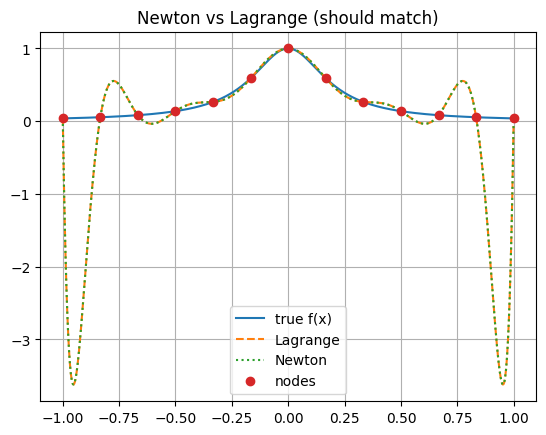

max |L - N| = 4.725109192804666e-13


In [ ]:
x_eval = np.linspace(-1, 1, 1000)
y_true = f_runge(x_eval)

n = 13
x_nodes = np.linspace(-1, 1, n)
y_nodes = f_runge(x_nodes)

yL = lagrange_interpolate(x_nodes, y_nodes, x_eval)

coef = divided_differences(x_nodes, y_nodes)
yN = newton_evaluate(x_nodes, coef, x_eval)

plt.figure()
plt.plot(x_eval, y_true, label="true f(x)")
plt.plot(x_eval, yL, '--', label="Lagrange")
plt.plot(x_eval, yN, ':', label="Newton")
plt.plot(x_nodes, y_nodes, 'o', label="nodes")
plt.title("Newton vs Lagrange (should match)")
plt.legend()
plt.grid(True)
plt.show()

print("max |L - N| =", max_abs_error(yL, yN))


## Exercise 4: Cubic Spline Interpolation (2 points)

### Objective
Compare cubic spline interpolation with global polynomial interpolation.

### Background
A cubic spline enforces continuity of:

$$
f(x), \quad f'(x), \quad f''(x)
$$

A natural spline satisfies:

$$
f''(x_0) = f''(x_n) = 0
$$

## Tasks
1. Using the Runge function and nodes from Exercise 2 (e.g., \(n=17\)), compute:
   - global Lagrange interpolant \(P_n(x)\),
   - natural cubic spline \(S(x)\).
2. Plot \(f(x)\), \(P_n(x)\), \(S(x)\), and the nodes.
3. Compare error metrics (RMSE and/or \(E_\infty\)).


### Questions
1. Which method oscillates less near the boundaries?
2. Why are splines more stable for many nodes?

---




## Answers 

Q1: The natural cubic spline method oscillates less near the boundries

Q2: Splines are more stable for many nodes becasue they only rely on the nearby nodes. Unlike other methods splines do not try to fit a function between all points, but rather only take into account the nearby nodes.

# Helper functions

In [ ]:
def f_runge(x):
    return 1/(1 + 25*x**2)

def f_eng(x):
    return np.exp(-x)*np.cos(2*np.pi*x)



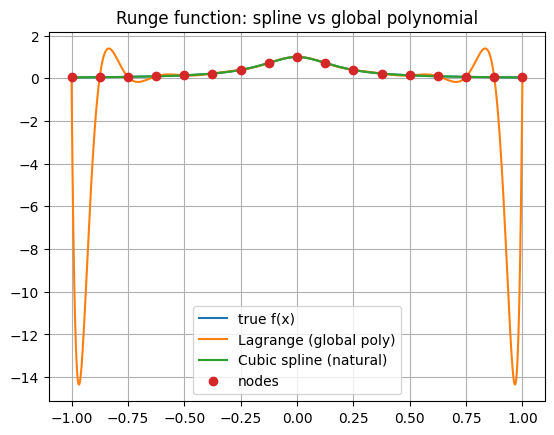

RMSE Lagrange: 3.2713594763125964
RMSE Spline  : 0.0010964462759843819


In [ ]:
if not SCIPY_AVAILABLE:
    print("SciPy not available. Skip Exercise 4 or install scipy.")
else:
    x_eval = np.linspace(-1, 1, 1000)
    y_true = f_runge(x_eval)

    n = 17
    x_nodes = np.linspace(-1, 1, n)
    y_nodes = f_runge(x_nodes)

    yL = lagrange_interpolate(x_nodes, y_nodes, x_eval)

    spline = CubicSpline(x_nodes, y_nodes, bc_type='natural')
    yS = spline(x_eval)

    plt.figure()
    plt.plot(x_eval, y_true, label="true f(x)")
    plt.plot(x_eval, yL, label="Lagrange (global poly)")
    plt.plot(x_eval, yS, label="Cubic spline (natural)")
    plt.plot(x_nodes, y_nodes, 'o', label="nodes")
    plt.title("Runge function: spline vs global polynomial")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("RMSE Lagrange:", rmse(y_true, yL))
    print("RMSE Spline  :", rmse(y_true, yS))


## Exercise 5: Practical Comparison on a Smooth Function (2 points)

### Objective
Compare interpolation methods on a smooth oscillatory function.

### Test Function
$$
f(x) = e^{-x}\cos(2\pi x), \quad x \in [0,1]
$$

## Tasks
1. Choose \(n=10\) equally spaced nodes on \([0,1]\) and sample the function.
2. Construct and evaluate:
   - Lagrange interpolant,
   - Newton interpolant,
   - (optional) natural cubic spline interpolant.
3. Plot the true function, each interpolant, and the nodes.
4. Compare error metrics for each method.


## Questions
1. Why is Taylor series not typically used as a general interpolator for tabulated data?
2. Which method performs best here, and what property of the function/data explains this?



## Answers 

Q1: Taylor series are not typically used as a general interpolator for tabulated data because they require derivatives that are unkown. 

Q2: Based on RMSE values Newton appears to preform slightly better than Lagrange, and better than natural cubic spline. Newton preforms the best because the interval is small, the function has little oscillation, and the data is an analytical rather than collected real world data. 


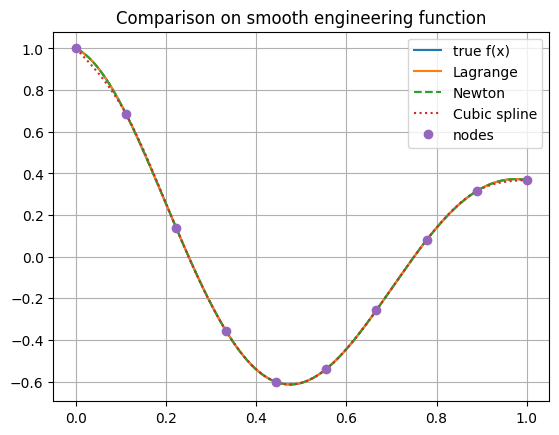

RMSE Lagrange: 1.5913911455302148e-05
RMSE Newton  : 1.5913911455171583e-05
RMSE Spline : 0.00628271280108646


In [ ]:
# ---- Ex 5: Practical comparison on smooth engineering function
x_eval2 = np.linspace(0, 1, 800)
y_true2 = f_eng(x_eval2)

n = 10
x_nodes2 = np.linspace(0, 1, n)
y_nodes2 = f_eng(x_nodes2)

yL2 = lagrange_interpolate(x_nodes2, y_nodes2, x_eval2)
coef2 = divided_differences(x_nodes2, y_nodes2)
yN2 = newton_evaluate(x_nodes2, coef2, x_eval2)

if SCIPY_AVAILABLE:
    spline2 = CubicSpline(x_nodes2, y_nodes2, bc_type='natural')
    yS2 = spline2(x_eval2)
else:
    yS2 = None

plt.figure()
plt.plot(x_eval2, y_true2, label="true f(x)")
plt.plot(x_eval2, yL2, label="Lagrange")
plt.plot(x_eval2, yN2, '--', label="Newton")
if yS2 is not None:
    plt.plot(x_eval2, yS2, ':', label="Cubic spline")
plt.plot(x_nodes2, y_nodes2, 'o', label="nodes")
plt.title("Comparison on smooth engineering function")
plt.legend()
plt.grid(True)
plt.show()

print("RMSE Lagrange:", rmse(y_true2, yL2))
print("RMSE Newton  :", rmse(y_true2, yN2))
if yS2 is not None:
    print("RMSE Spline :", rmse(y_true2, yS2))

# Final Discussion (Short Summary) (4 points)

Write a short paragraph (5–10 sentences) summarizing your main observations. Address:

- Where each method (Taylor series, Lagrange, Newton, cubic splines) performs well.
- Where each method performs poorly.
- The effect of increasing the number of interpolation points on accuracy and stability.
- The influence of node spacing on interpolation quality (especially for the Runge function).
- Why cubic spline interpolation is often preferred over high-degree global polynomials in practical applications.

Focus on qualitative interpretation supported by your numerical results and figures.


In this method we analyzied 4 methods of interpolating a function, those being Taylor series, Lagrange interpolation, Newton interpolation, and cubic splines. For the Taylor series we saw that it works well for a local aproximation near a point, and when we have access to the derivatives. It preforms poorly when the estimated value is far from the expansion point, as seen in the created plots, and with tabulated data, where derivaties are unavailable. Lagrange interpolation works well a global polynomial is desired to represent the data, and when the number of nodes or data points is small. It strugles when the number of nodes is large(Runge phenomenon), or when more nodes or data wants to be added.
Newton interpolation works well when a global polynomial is desired, and when nodes may be added later. It struggles in similar ways to Lagrange interpolation, except for when new nodes are added. Cubic splines work well when there are many data points, when the underlying function could oscilate often, and a global polynomial is not needed. It performs poorly or less well than the other methods when the interval is small, the function is smooth, as in the last graph, or a global polynomial is desired. We can see in exersise two that when more data points are added the accuracy of the interpolation increases, however the stability for Newton and Lagrange interpolation can greatly decrease. Increasing the number of data points does not really effect spline interpolation as it creates local, low order polynomials. As seen in exersises two, three, and four equally spaced nodes can cause large oscilation near the end points of an interpolation, especially in cases similar to the Runge function. In this lab the size of the data was reatively low, but in many practical applications cubic splines are often the preferred method as they can be used with tabulated  data, are computationaly cheaper, and can be more stable.  